In [166]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Pre-process with TestDataset

During the SKA Date Challenge 3a, participants were provided with a TestDataset (= EoR + noise + instrumental effects) over the 166-181 MHz range without foreground as well as its 2D cylindrical power spectrum, which allows to test 1. 2D cylindrical power spectrum estimation, 2. primary beam and PSF correction, and 3. the SDC3 submission format.

This notebook is to test our pipeline by comparing the output power spectrum with the provided ones.

Ref. https://sdc3.skao.int/challenges/foregrounds/data

# Contents
1. Read inputs including the TestDataset
2. Densityflux to brightness temperature
3. Cut to 3x3 deg^2
4. Smoothing
5. Beam correction
6. ICA for PSF correction
7. Pk measurement - Find PSF normalization factor 

In [167]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import FlatLambdaCDM

In [200]:
#================= Define the path to the package
dir_path = '/home/minjioh/KORSDC_FGremove/'
#================= Define the path to the package

In [169]:
import sys
sys.path.append(dir_path+"tools")
from tools import RA_DEC_fq 
from tools import pk_3D_to_2D 
from tools import DensityFlux_to_Temp 

In [170]:
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import FastICA

# 1. Read inputs including the TestDataset

In [171]:
filename = dir_path+'ancillary/bins_kper.txt'
kper = np.loadtxt(filename)

filename = dir_path+'ancillary/bins_kpar.txt'
kpar = np.loadtxt(filename)

filename = dir_path+'ancillary/TestDatasetTRUTH_166MHz-181MHz.data'
Truth = np.loadtxt(filename)

In [172]:
weights= ['msw', 'msn']
data=['psf', 'image']

In [173]:
########## 'TestDataset.msn_image.fits' is too large to be shared here,
########## so please find the intput via the link and download to the 'input' directory
# ref. https://drive.google.com/drive/folders/1acIWVwGG8_aLqHKoLJvDCkJu2pcesgH6
weight = weights[1]
datum=data[1]

filename = dir_path+'input/TestDataset.{}_{}.fits'.format(weight,datum)
print("Reading... ", filename)
fx = fits.open(filename)
print(fx.info())

Reading...  /home/minjioh/KORSDC_FGremove/input/TestDataset.msn_image.fits
Filename: /home/minjioh/KORSDC_FGremove/input/TestDataset.msn_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   (2048, 2048, 151)   float32   
None


In [174]:
RA, DEC, fq = RA_DEC_fq(fx)

RA range      : -4.55 to 4.55
DEC range     : -34.55 to -25.45
redshift range: 6.85 to 7.55


# 2. Densityflux to brightness temperature

In [175]:
cart_map_cut = DensityFlux_to_Temp(fx)
del fx

This is new


# 3. Cut image to 3x3 deg^2

In [176]:
TEST = abs(RA)< 1.5 # deg
RA_min = np.where(TEST==True)[0][0]
RA_max = np.where(TEST==True)[0][-1]+1

Image_3x3 = cart_map_cut[:,RA_min:RA_max,RA_min:RA_max]
RA_3x3 = RA[RA_min:RA_max]
DEC_3x3 = DEC[RA_min:RA_max]

print(Image_3x3.shape)
print(RA_3x3.shape)
print(DEC_3x3.shape)
print(fq.shape)

del cart_map_cut
del RA
del DEC

(151, 675, 675)
(675,)
(675,)
(151,)


In [177]:
RA_3x3[337] # 0~ 674, centered well

0.0

data shape to be plotted:  (675, 675)
min/max of the pixel values:  -0.055235994160262925 0.05259084513603597
mean= 6.52615374182273e-05
std= 0.011902456277064113
 
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -0.05905492289535723 0.04952012327379458
mean= 0.00011769131988735622
std= 0.01219123160044379
 
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -0.055963882839001736 0.05214682280626958
mean= -0.00022774907588512627
std= 0.012142232054133537
 
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -0.05566568777250502 0.04969260224150736
mean= -0.000227738835724976
std= 0.012207072385063952
 
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -0.05347204862664586 0.05106262072619934
mean= 0.0002477114251564295
std= 0.012531982324490504
 
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -0.05590599998088208 0.05075367222444746
mean= -0.0009736470496587064
std= 0.012491102692437134
 


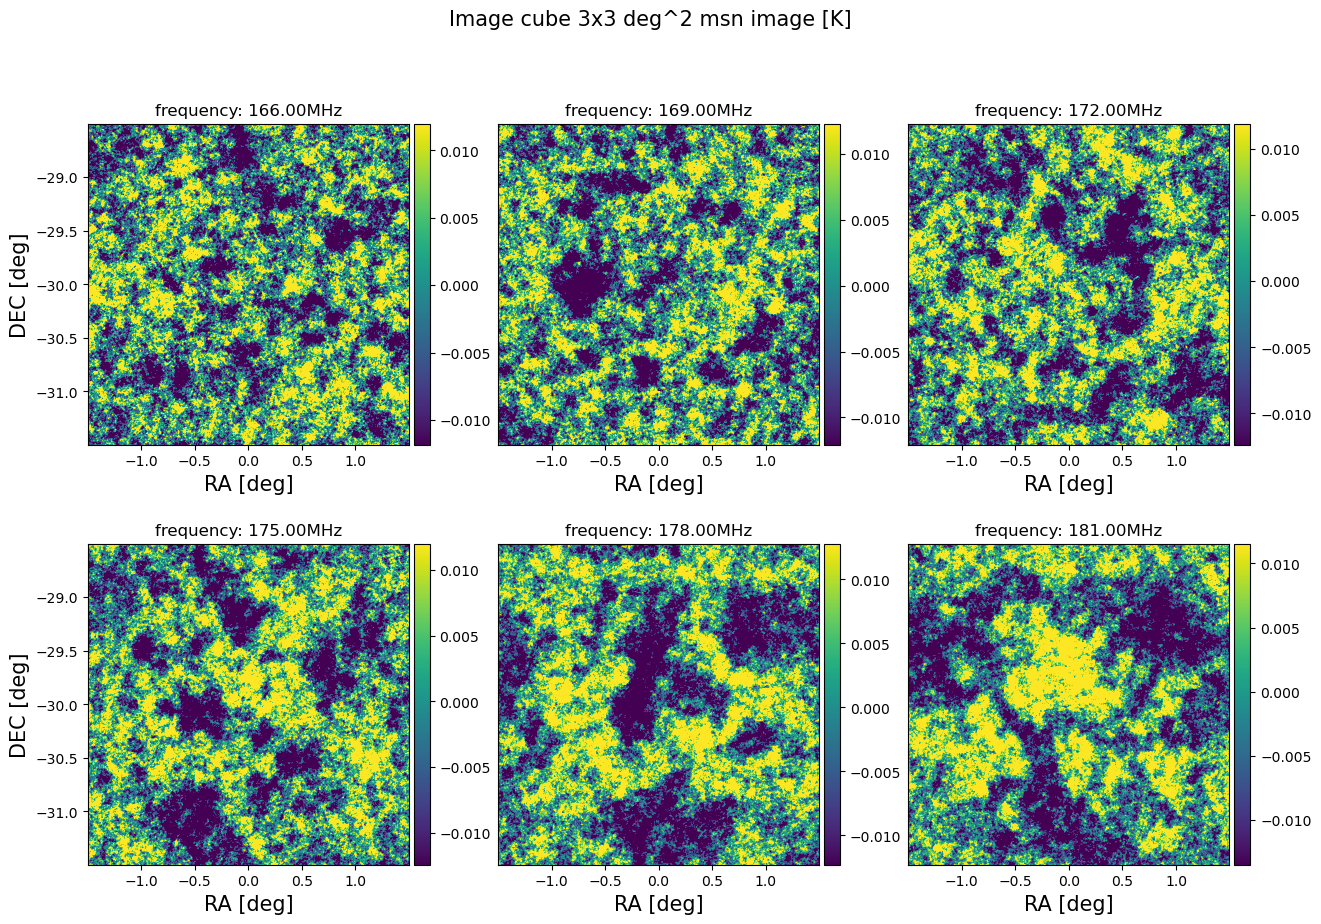

In [178]:
sample=np.array([0, 30, 60, 90, 120, 150])

plt.figure(figsize=(15,10))
ithf=0
plt.suptitle("Image cube 3x3 deg^2 {} {} [K]".format(weight,datum),fontsize=15)
for ithf in range(6):
    plt.subplot(2,3,1+ithf)
    plt.title("frequency: {:.2f}MHz".format(fq[sample][ithf]))

    ax = plt.gca()
    myMatrix =Image_3x3[sample][ithf]

    print("data shape to be plotted: ", myMatrix.shape)
    print("min/max of the pixel values: ",np.min(myMatrix), np.max(myMatrix))

    vmin=np.std(myMatrix)
    vmean=np.mean(myMatrix)
    print("mean=", vmean)
    print("std=", vmin)
    im = plt.imshow(myMatrix,extent=([min(RA_3x3), max(RA_3x3), min(DEC_3x3), max(DEC_3x3)]),vmin=vmean-vmin,vmax=vmean+vmin)
    plt.xlabel("RA [deg]",fontsize=15)
    if ithf==0 or ithf==3:
        plt.ylabel("DEC [deg]",fontsize=15)
    else:
        plt.yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im,cax=cax)
    print(" ")

In [179]:
# FT
ft = np.fft.fftn(Image_3x3.astype('float64'))
Tk = np.fft.fftshift(ft)
del ft

# Pk
pk2_Image_3x3, nk2_Image_3x3 = pk_3D_to_2D(kper,Tk,RA_3x3,fq)

(10,)
(151, 675, 675)
(675,)
(151,)
   314.50274013780376  Mpc
   162.43130285133157  Mpc


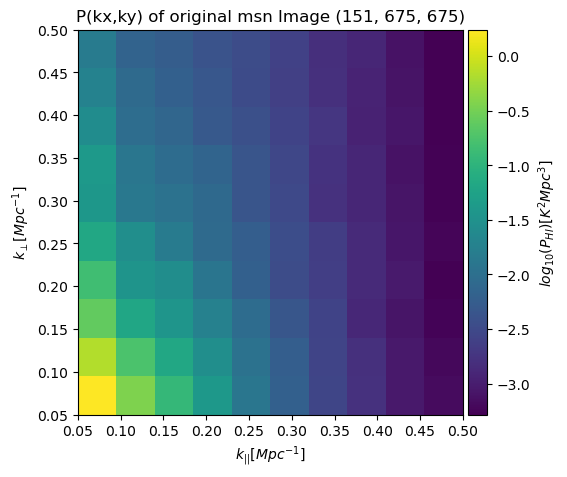

In [180]:
plt.figure(figsize=(15,5))

plt.title("P(kx,ky) of original {} Image {}".format(weight,Image_3x3.shape))
ax = plt.gca()
myMatrix =np.log10(pk2_Image_3x3)
im = plt.imshow(np.flip(myMatrix,0),extent=([min(kper), max(kper), min(kpar), max(kpar)]))
plt.ylabel(r"$k_{\perp} [Mpc^{-1}]$",fontsize=10)
plt.xlabel(r"$k_{||} [Mpc^{-1}]$",fontsize=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax)
cbar.set_label(r"$log_{10}(P_{HI}) [K^{2}Mpc^{3}]$",fontsize=10)

In [181]:
del Tk

# 4. Smoothing

In [182]:
sigma0 = 3.0

sigma_filter = np.zeros(Image_3x3.shape[0])

for i in range(Image_3x3.shape[0]):
    sigma_filter[i] = sigma0*(fq[-1]/fq[i])

In [183]:
Image_3x3_smooth = np.zeros(Image_3x3.shape)
for i in range(Image_3x3.shape[0]):
    Image_3x3_smooth[i] = gaussian_filter(Image_3x3[i], sigma=sigma_filter[i])

In [184]:
# FT
ft = np.fft.fftn(Image_3x3_smooth.astype('float64'))
Tk = np.fft.fftshift(ft)
del ft

pk2_Image_3x3_smooth, nk2_Image_3x3_smooth = pk_3D_to_2D(kper,Tk,RA_3x3,fq)

(10,)
(151, 675, 675)
(675,)
(151,)
   314.50274013780376  Mpc
   162.43130285133157  Mpc


# 5. Beam correction

In [185]:
########## 'station_beam.fits' is too large to be shared here,
########## so please find the intput via the link and download to the 'ancillary' directory.
# ref. https://drive.google.com/drive/folders/13hHi5KJlX2GUrSJxuhCEqsjo0s5UgCXp
# filename = dir_path+'ancillary/station_beam.fits'
filename = '/home/dhlee/SDC3/TestData/station_beam.fits'

print("Reading... ", filename)
fx_beam = fits.open(filename)
print(fx_beam.info())

Reading...  /home/dhlee/SDC3/TestData/station_beam.fits
Filename: /home/dhlee/SDC3/TestData/station_beam.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   (2560, 2560, 901)   float32   
None


In [186]:
RA1, DEC1, fq1 = RA_DEC_fq(fx_beam)

RA range      : -5.69 to 5.68
DEC range     : -35.68 to -24.31
redshift range: 6.24 to 12.40


In [187]:
TEST = abs(RA1)< 1.5 # deg
RA_min = np.where(TEST==True)[0][0]
RA_max = np.where(TEST==True)[0][-1]+1

beam_3x3 = fx_beam['PRIMARY'].data[600:600+151,RA_min:RA_max,RA_min:RA_max]
RA1_3x3 = RA1[RA_min:RA_max]
DEC1_3x3 = DEC1[RA_min:RA_max]

print(beam_3x3.shape)
print(RA1_3x3.shape)
print(DEC1_3x3.shape)
print(fq1[600:600+151].shape)

del fx_beam
del RA1
del DEC1

(151, 675, 675)
(675,)
(675,)
(151,)


In [188]:
RA1_3x3[337] # 0~ 674

0.0

In [189]:
Tx = Image_3x3_smooth/beam_3x3
del Image_3x3_smooth
del beam_3x3

In [190]:
# FT
ft = np.fft.fftn(Tx.astype('float64'))
Tk = np.fft.fftshift(ft)
del ft

pk2_Tx, nk2_Tx = pk_3D_to_2D(kper,Tk,RA_3x3,fq)

(10,)
(151, 675, 675)
(675,)
(151,)
   314.50274013780376  Mpc
   162.43130285133157  Mpc


# 6. ICA for PSF correction

In [191]:
total_pixels = Tx.shape[1]*Tx.shape[2]
flattened_data = np.reshape(Tx,(151,total_pixels))

In [192]:
n_components = 1
ica = FastICA(n_components=n_components)
S_ = ica.fit_transform(flattened_data.T)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

In [193]:
print(flattened_data.shape,A_.shape,S_.shape,ica.mean_.shape)

(151, 455625) (151, 1) (455625, 1) (151,)


In [194]:
num_freq_bins = Tx.shape[0]

In [195]:
ica_map = np.dot(S_, A_.T) + ica.mean_

diff_map = np.zeros([num_freq_bins,total_pixels])
for i_freq in range(0,num_freq_bins):
    diff_map[i_freq,:] = flattened_data[i_freq,:] - ica_map[:,i_freq]
    
diff_map_ra_dec = np.reshape(diff_map,(Tx.shape[0],Tx.shape[1],Tx.shape[2]))

# 7. Pk measurement - Find PSF normalization factor 

In [196]:
# FT
ft = np.fft.fftn(diff_map_ra_dec.astype('float64'))
Tk = np.fft.fftshift(ft)
del ft

In [197]:
pk2, nk2 = pk_3D_to_2D(kper,Tk,RA_3x3,fq)

(10,)
(151, 675, 675)
(675,)
(151,)
   314.50274013780376  Mpc
   162.43130285133157  Mpc


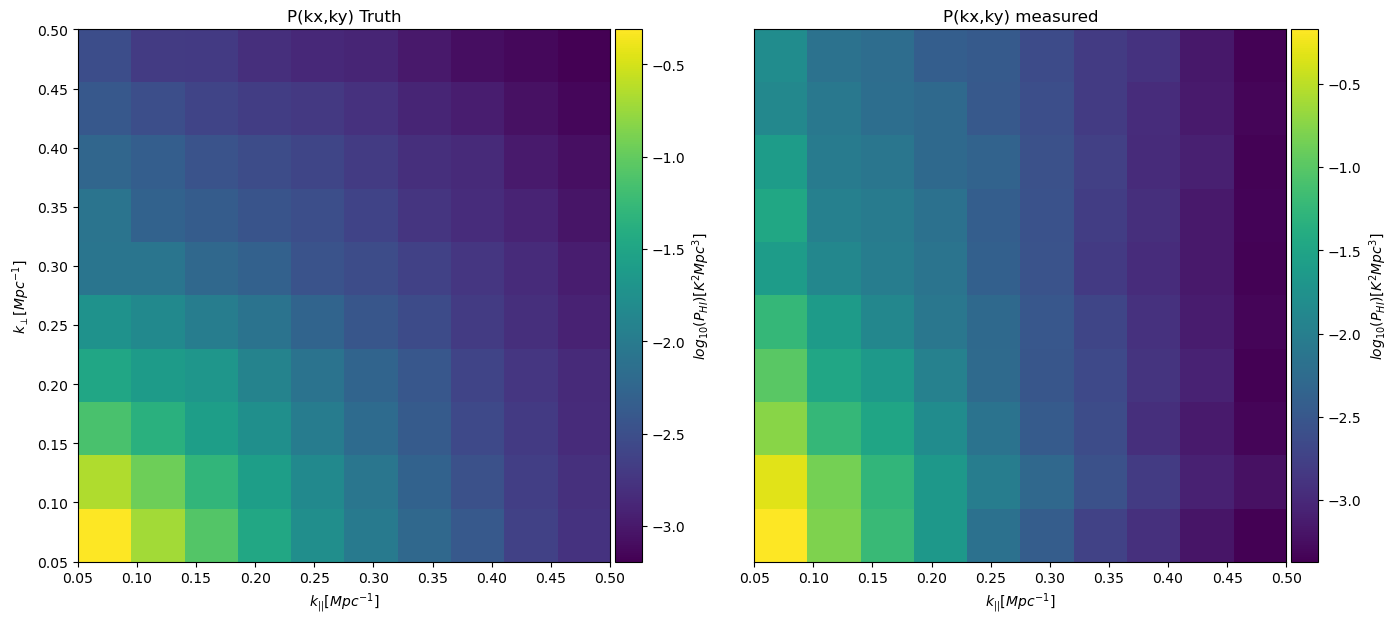

In [202]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.title("P(kx,ky) Truth".format(weight))
ax = plt.gca()
myMatrix =np.log10(Truth)
im = plt.imshow(np.flip(myMatrix,0),extent=([min(kper), max(kper), min(kpar), max(kpar)]))
plt.ylabel(r"$k_{\perp} [Mpc^{-1}]$",fontsize=10)
plt.xlabel(r"$k_{||} [Mpc^{-1}]$",fontsize=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax)
cbar.set_label(r"$log_{10}(P_{HI}) [K^{2}Mpc^{3}]$",fontsize=10)

plt.subplot(1,2,2)
plt.title("P(kx,ky) measured".format(weight))
ax = plt.gca()
myMatrix =np.log10(pk2/3) # THIS ADDITIONAL FACTOR plays a role of normalization for PSF for the main dataset.
im = plt.imshow(np.flip(myMatrix,0),extent=([min(kper), max(kper), min(kpar), max(kpar)]))
plt.yticks([])
plt.xlabel(r"$k_{||} [Mpc^{-1}]$",fontsize=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax)
cbar.set_label(r"$log_{10}(P_{HI}) [K^{2}Mpc^{3}]$",fontsize=10)

- The ADDITIONAL FACTOR "3" plays a role of re-normalization for PSF when we deal with the main dataset here:

KORSDC_FGremove/main/Reproducibility_part3_with_beam_corrected_MainDataset.ipynb

# 8. Summary plots

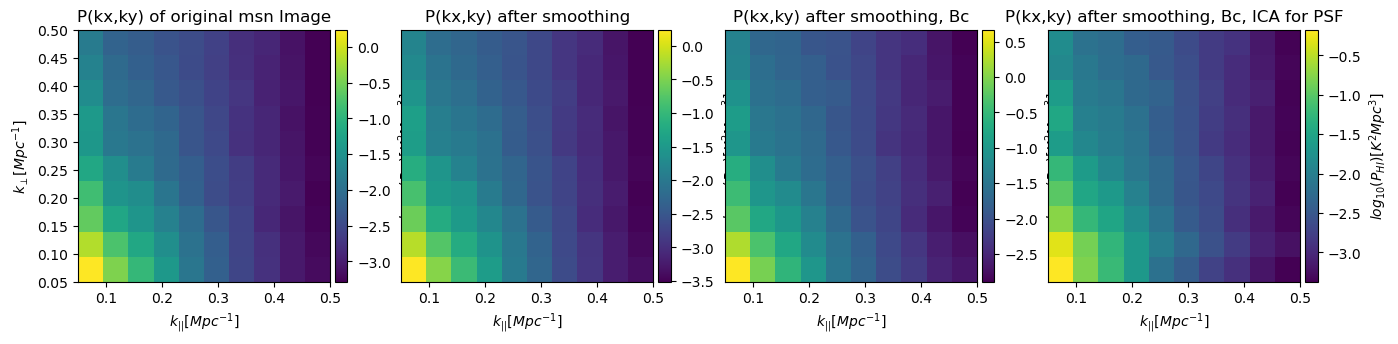

In [203]:
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.title("P(kx,ky) of original {} Image".format(weight))
ax = plt.gca()
myMatrix =np.log10(pk2_Image_3x3)
im = plt.imshow(np.flip(myMatrix,0),extent=([min(kper), max(kper), min(kpar), max(kpar)]))
plt.ylabel(r"$k_{\perp} [Mpc^{-1}]$",fontsize=10)
plt.xlabel(r"$k_{||} [Mpc^{-1}]$",fontsize=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax)
cbar.set_label(r"$log_{10}(P_{HI}) [K^{2}Mpc^{3}]$",fontsize=10)

plt.subplot(1,4,2)
plt.title("P(kx,ky) after smoothing".format(weight))
ax = plt.gca()
myMatrix =np.log10(pk2_Image_3x3_smooth)
im = plt.imshow(np.flip(myMatrix,0),extent=([min(kper), max(kper), min(kpar), max(kpar)]))
# plt.ylabel(r"$k_{\perp} [Mpc^{-1}]$",fontsize=10)
plt.yticks([])
plt.xlabel(r"$k_{||} [Mpc^{-1}]$",fontsize=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax)
cbar.set_label(r"$log_{10}(P_{HI}) [K^{2}Mpc^{3}]$",fontsize=10)

plt.subplot(1,4,3)
plt.title("P(kx,ky) after smoothing, Bc".format(weight))
ax = plt.gca()
myMatrix =np.log10(pk2_Tx)
im = plt.imshow(np.flip(myMatrix,0),extent=([min(kper), max(kper), min(kpar), max(kpar)]))
# plt.ylabel(r"$k_{\perp} [Mpc^{-1}]$",fontsize=10)
plt.yticks([])
plt.xlabel(r"$k_{||} [Mpc^{-1}]$",fontsize=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax)
cbar.set_label(r"$log_{10}(P_{HI}) [K^{2}Mpc^{3}]$",fontsize=10)

plt.subplot(1,4,4)
plt.title("P(kx,ky) after smoothing, Bc, ICA for PSF".format(weight))
ax = plt.gca()
myMatrix =np.log10(pk2/3.)
im = plt.imshow(np.flip(myMatrix,0),extent=([min(kper), max(kper), min(kpar), max(kpar)]))
# plt.ylabel(r"$k_{\perp} [Mpc^{-1}]$",fontsize=10)
plt.yticks([])
plt.xlabel(r"$k_{||} [Mpc^{-1}]$",fontsize=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax)
cbar.set_label(r"$log_{10}(P_{HI}) [K^{2}Mpc^{3}]$",fontsize=10)
plt.savefig(dir_path+'plots/pk_TestDataset_summary.png')

# Now, we are ready to deal with the MainDataset which includes foregound. Before we apply our pipeline to the MainDataset, we need to remove point sources after the beam correction. Please check the follow: 
KORSDC_FGremove/main/Reproducibility_part2_with_SE.py